# Recipe Investigation: What types of recipes tend to have higher average ratings?

**Name(s)**: Evelyn Huang and Jacqueline Zhong

**Website Link**: https://evelynh037.github.io/datascience_projects

## Code

In [2]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
pd.options.plotting.backend = 'plotly'

import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Used for plotting examples.
def create_kde_plotly(df, group_col, group1, group2, vals_col, title=''):
    fig = ff.create_distplot(
        hist_data=[df.loc[df[group_col] == group1, vals_col], df.loc[df[group_col] == group2, vals_col]],
        group_labels=[group1, group2],
        show_rug=False, show_hist=False,
        colors=['#ef553b', '#636efb'],
    )
    return fig.update_layout(title=title)

In [3]:
#get data
file1 = os.path.join("food_data","RAW_interactions.csv")
file2 = os.path.join("food_data", "RAW_recipes.csv")
raw_in = pd.read_csv(file1)
raw_recipe = pd.read_csv(file2)

In [4]:
#merge + add average
df = raw_recipe.merge(raw_in, left_on = 'id', right_on = 'recipe_id', how = 'left')
df = df.replace(0, np.nan)
means = df.groupby('id')['rating'].mean()
means = means.to_frame().rename(columns = {'rating': 'Average_rating'})
df = df.merge(means, left_on = 'id', right_index = True, how = 'left')


### Cleaning and EDA

In [5]:
#data cleaning
wanted = df[['name', 'id', 'minutes','nutrition','n_steps','n_ingredients','Average_rating']]
wanted["nutrition"] = wanted["nutrition"].str[1:-1].str.split(",")
wanted["calories (#)"] = wanted["nutrition"].str[0].astype(float)
wanted["total fat (PDV)"] = wanted["nutrition"].str[1].astype(float)
wanted["sugar (PDV)"] = wanted["nutrition"].str[2].astype(float)
wanted["sodium (PDV)"] = wanted["nutrition"].str[3].astype(float)
wanted["protein (PDV)"] = wanted["nutrition"].str[4].astype(float)
wanted["saturated fat (PDV)"] = wanted["nutrition"].str[5].astype(float)
wanted["carbohydrates (PDV)"] = wanted["nutrition"].str[6].astype(float)
wanted = wanted.drop(columns = "nutrition")

(array([6.97000e+02, 3.00000e+00, 4.80000e+01, 1.00000e+01, 7.53000e+02,
        1.02000e+02, 4.35000e+02, 8.40000e+01, 3.51200e+03, 8.64000e+02,
        3.03700e+03, 1.94600e+03, 2.15840e+04, 1.36410e+04, 4.09950e+04,
        1.43941e+05]),
 array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
        3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 16 artists>)

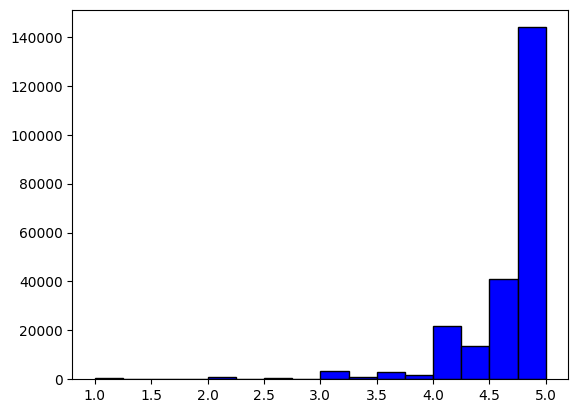

In [6]:
#Univariate Analysis
plt.hist(wanted['Average_rating'], color = 'blue', edgecolor = 'black',
         bins = int(80/5))

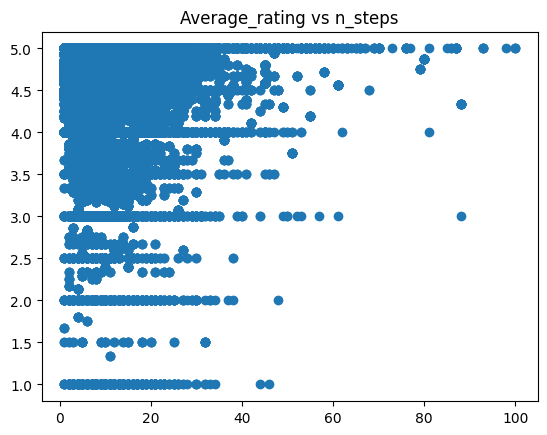

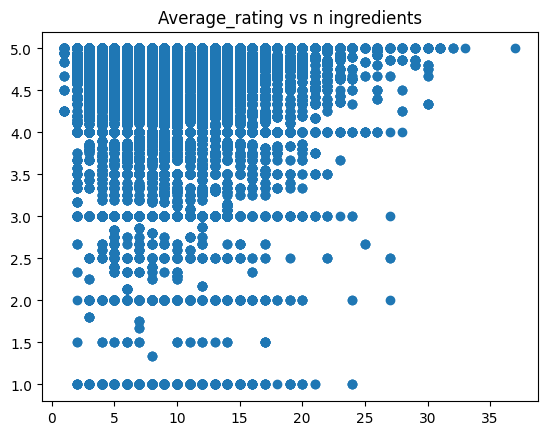

In [7]:
#Bivariate Analysis
ax = plt.subplot()
plt.scatter(y = wanted['Average_rating'], x = wanted['n_steps'])
plt.title("Average_rating vs n_steps")
plt.show()
ax = plt.subplot()
plot2 = plt.scatter(y = wanted['Average_rating'], x = wanted['n_ingredients'])
plt.title("Average_rating vs n ingredients")
plt.show()

In [8]:
#Interesting Aggregates
wanted["rating range"] = wanted["id"] == 0
wanted.loc[(wanted["Average_rating"] > 4), "rating range"] = "(4,5]"
wanted.loc[(wanted["Average_rating"] <= 4) & (wanted["Average_rating"] > 3), "rating range"] = "(3,4]"
wanted.loc[(wanted["Average_rating"] <= 3) & (wanted["Average_rating"] > 2), "rating range"] = "(2,3]"
wanted.loc[(wanted["Average_rating"] <= 2) & (wanted["Average_rating"] > 1), "rating range"] = "(1,2]"
wanted.loc[(wanted["Average_rating"] <= 1) & (wanted["Average_rating"] >= 0), "rating range"] = "[0,1]"
wanted.loc[wanted["Average_rating"].isna(), "rating range"] = "nan"
wanted["step range"] = wanted["id"] == 0
wanted.loc[(wanted["n_steps"] > 80), "step range"] = "(80,100]"
wanted.loc[(wanted["n_steps"] <= 80) & (wanted["n_steps"] > 60), "step range"] = "(60,80]"
wanted.loc[(wanted["n_steps"] <= 60) & (wanted["n_steps"] > 40), "step range"] = "(40,60]"
wanted.loc[(wanted["n_steps"] <= 40) & (wanted["n_steps"] > 20), "step range"] = "(20,40]"
wanted.loc[(wanted["n_steps"] <= 20) & (wanted["n_steps"] >= 0), "step range"] = "[20,0]"
wanted.pivot_table(index='step range', 
                     columns='rating range', 
                     values='n_ingredients', 
                     aggfunc='count')

rating range,"(1,2]","(2,3]","(3,4]","(4,5]","[0,1]",nan
step range,,,,,,
"(20,40]",68.0,245.0,1245.0,10968.0,50.0,251.0
"(40,60]",1.0,8.0,52.0,914.0,2.0,24.0
"(60,80]",NaN,1.0,1.0,85.0,NaN,3.0
"(80,100]",NaN,1.0,1.0,31.0,NaN,2.0
"[20,0]",720.0,3714.0,22108.0,190792.0,645.0,2497.0


### Assessment of Missingness

In [11]:
#NMAR1 if name is formatted, description is missing
df[df["steps"].isna()]
df["description"]
df[df["description"].isna()]
#df[-df["description"].isna()]["name"].unique()[20:30]

#NMAR2 higher rating so people don't put review for that(MAR)
df[df["review"].isna()]
#missing columns [minutes, description, rating and review]
df[df["rating"].isna()]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,Average_rating
11,50 chili for the crockpot,501028,345.0,2628680,2013-05-28,"['course', 'main-ingredient', 'cuisine', 'prep...","[270.2, 19.0, 26.0, 48.0, 52.0, 21.0, 4.0]",4,['combine all ingredients in a 7-quart crockpo...,"first, thank you to *parsley* - chef # 199848 ...","['stewing beef', 'stewing pork', 'white onion'...",22,1.800120e+09,501028.0,2013-10-26,NaN,We tried it last weekend and it the entire fam...,5.00
16,lplermagronen,455351,55.0,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'prepar...","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,['heat oven to 375f set a large pot of salted ...,"known as swiss mac n cheese, älplermagronen wa...","['potato', 'penne pasta', 'onions', 'butter', ...",8,1.255389e+07,455351.0,2014-10-17,NaN,"I made this using emmentaler, a swiss cheese. ...",NaN
20,der wiener schnitzel style chili dog sauce,523359,55.0,2000414501,2015-08-27,"['60-minutes-or-less', 'time-to-make', 'prepar...","[259.7, 23.0, 18.0, 31.0, 34.0, 28.0, 4.0]",16,['in a large size dutch oven or large size dee...,this was the best chili dog ever invented! i l...,"['ground beef', 'ground pork', 'water', 'corns...",14,1.142430e+05,523359.0,2015-09-05,NaN,This recipe is almost exactly like firemandave...,NaN
94,she crab cream of crab soup,275675,45.0,711025,2008-01-02,"['60-minutes-or-less', 'time-to-make', 'course...","[777.3, 50.0, 27.0, 144.0, 62.0, 69.0, 12.0]",3,"['combine all ingredients in double boiler', '...","i got this recipe from my grandmother, who was...","['cream of mushroom soup', 'cream of celery so...",10,7.181310e+05,275675.0,2008-01-13,NaN,Me and my wife made this recipe tonight. Somew...,4.75
95,she crab cream of crab soup,275675,45.0,711025,2008-01-02,"['60-minutes-or-less', 'time-to-make', 'course...","[777.3, 50.0, 27.0, 144.0, 62.0, 69.0, 12.0]",3,"['combine all ingredients in double boiler', '...","i got this recipe from my grandmother, who was...","['cream of mushroom soup', 'cream of celery so...",10,2.067470e+05,275675.0,2008-01-15,NaN,NO ONE from Maryland will appreciate this if y...,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234385,zuppa my weight watcher version of the olive g...,328409,70.0,690050,2008-10-01,"['time-to-make', 'course', 'preparation', 'occ...","[342.4, 10.0, 10.0, 39.0, 48.0, 8.0, 15.0]",7,"['in a big soup pot', 'cook ground turkey with...",this is the way that i have made a low fat ve...,"['ground turkey', 'black pepper', 'ground sage...",16,2.618489e+06,328409.0,2013-01-06,NaN,this recipe is terrible!<br/>For one the last ...,5.00
234389,zuppa toscana from olive garden,388574,60.0,634137,2009-09-03,"['60-minutes-or-less', 'time-to-make', 'course...","[531.7, 59.0, 13.0, 74.0, 38.0, 87.0, 9.0]",11,"['remove sausage from casings if applicable', ...",this is my favorite soup. this recipe is suppo...,"['mild italian sausage', 'crushed red pepper f...",10,1.480020e+05,388574.0,2012-10-06,NaN,Family favorite! Kids request this on cold win...,4.50
234405,zwiebelwhe swiss onion tart,410985,165.0,993604,2010-01-30,"['weeknight', 'time-to-make', 'course', 'main-...","[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",13,1.437197e+06,410985.0,2010-01-31,NaN,????how many onions?,5.00
234407,zwiebelwhe swiss onion tart,410985,165.0,993604,2010-01-30,"['weeknight', 'time-to-make', 'course', 'main-...","[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",13,2.001558e+09,410985.0,2017-05-28,NaN,It's really Swiss onion tart?,5.00


In [23]:
#Missing dependency
#dependent 1
wanted['rating_missing'] = wanted['Average_rating'].isnull()
create_kde_plotly(wanted, 'rating_missing', True, False,'n_steps', 'rating vs n_steps')
observed_diff = wanted.groupby('rating_missing')['n_steps'].mean().diff().abs().iloc[-1]
diffs = []
shuffled = wanted.copy()
for n in range(1000):
    shuffled['shuffled'] = np.random.permutation(shuffled['rating_missing'])
    diff = shuffled.groupby('shuffled')['n_steps'].mean().diff().abs().iloc[-1]
    diffs.append(diff)
p_value_step = (diffs > observed_diff).mean()
p_value_step

0.0

In [24]:
#dependent 2
df2 = wanted[wanted['minutes'].isnull() == False]
maxi = np.percentile(df2.minutes,95)
df2 = df2.loc[df2['minutes'] <= maxi]
create_kde_plotly(df2, 'rating_missing', True, False,'minutes', 'rating vs minutes')
observed_diff = df2.groupby('rating_missing')['minutes'].mean().diff().abs().iloc[-1]
diffs = []
for n in range(1000):
    df2['shuffled'] = np.random.permutation(df2['rating_missing'])
    diff = df2.groupby('shuffled')['minutes'].mean().diff().abs().iloc[-1]
    diffs.append(diff)
p_value_minute = (diffs > observed_diff).mean()
p_value_minute

0.0

In [28]:
#not dependent
create_kde_plotly(wanted, 'rating_missing', True, False,'protein (PDV)', 'rating vs protein')
observed_ks_p = ks_2samp(wanted.loc[wanted['rating_missing'] == True, 'protein (PDV)'], wanted.loc[wanted['rating_missing'] == False, 'protein (PDV)']).statistic
shuffled4 = wanted.copy()

ks_stats = []
for i in range(500):
    shuffled4['rating_missing'] = np.random.permutation(shuffled4['rating_missing'])
    groups = shuffled4.groupby('rating_missing')['protein (PDV)']
    ks_stat = ks_2samp(groups.get_group(True), groups.get_group(False)).statistic
    ks_stats.append(ks_stat)
p_value_protein = (ks_stats > observed_ks_p).mean()
p_value_protein

0.236

### Hypothesis Testing

In [29]:
def total_variation_distance(dist1, dist2):
    return np.sum(np.abs(dist1 - dist2)) / 2

In [30]:
#null: receipes with steps below 50th percentile's distribution of rating is sampling from the population of all receipe
#alternative: receipes with steps above 9(50th percentile)'s distribution of rating is not sampling from the population of all receipe
fif_p = np.percentile(wanted['n_steps'], 50)
below_df = wanted[wanted['n_steps'] <= np.percentile(wanted['n_steps'], 50)]
distribution = (wanted.groupby("range").count()/wanted.shape[0])[["name"]].rename(columns={"name":"population"})
#distribution["sample"] = below_df
distribution["sample"] = (below_df.groupby("range").count()/below_df.shape[0])["name"]
observed_tvd = total_variation_distance(distribution['population'], distribution['sample'])
num_reps = 100_000
eth_draws = np.random.multinomial(wanted.shape[0], distribution['population'], size=num_reps) / wanted.shape[0]
tvds = np.sum(np.abs(eth_draws - distribution['population'].to_numpy()), axis=1) / 2
p_value = (tvds >= observed_tvd).mean()
p_value

KeyError: 'range'

In [ ]:
fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=20, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd, line_color='red')
fig